In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras_tuner as kt
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

from training_string_standardization import custom_standardization

No file or directory found at hypermodel-string_regex_punctuation.keras


OSError: No file or directory found at hypermodel-string_regex_punctuation.keras

In [5]:
epochs = 75
batch_size = 32
embedding_dim = 64
max_features = 10000
sequence_length = 1000
seed = 42

In [6]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '../data_preparation/training', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    '../data_preparation/training', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    '../data_preparation/testing', 
    batch_size=batch_size)

Found 26238 files belonging to 6 classes.
Using 20991 files for training.
Found 26238 files belonging to 6 classes.
Using 5247 files for validation.
Found 205 files belonging to 8 classes.


In [422]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)

In [423]:
labels = os.listdir(os.getcwd() +'/data/training')
print(labels)

for label in labels:
  folder = os.getcwd() +'/data/training/' + label 
  files = os.listdir(folder)
  filePath = folder + '/' + files[0]
  print('Standardizing ' + filePath)
  with open(filePath, 'r', encoding = 'utf-8') as file:
    content = file.read()
    print('before',filePath, content)
    print('after', filePath, custom_standardization(content))
    print('--')

print(custom_standardization("""
import URLSearchParams from './classes/URLSearchParams.js'
import FormData from './classes/FormData.js'

export default {
  isNode: true,
  classes: {
    URLSearchParams,
    FormData,
    Blob: typeof Blob !== 'undefined' && Blob || null
  },
  protocols: [ 'http', 'https', 'file', 'data' ]
};

"""))

print(custom_standardization('use strict";Object.defineProperty(exports,"__esModule",{value:!0}),exports.default=void 0;var _URLSearchParams=_interopRequireDefault(require("./classes/URLSearchParams.js")),_FormData=_interopRequireDefault(require("./classes/FormData.js"));function _interopRequireDefault(e){return e&&e.__esModule?e:{default:e}}var _default=exports.default={isNode:!0,classes:{URLSearchParams:_URLSearchParams.default,FormData:_FormData.default,Blob:"undefined"!=typeof Blob&&Blob||null},protocols:["http","https","file","data"]};'))

['jjencode', 'jsconfuser', 'obfuscate', 'plain', 'plain-es5', 'uglify']
Standardizing c:\workspace\tf-text-classification/data/training/jjencode/axios-adapters.txt


before c:\workspace\tf-text-classification/data/training/jjencode/axios-adapters.txt _=~[];_={___:++_,$$$$:(![]+"")[_],__$:++_,$_$_:(![]+"")[_],_$_:++_,$_$$:({}+"")[_],$$_$:(_[_]+"")[_],_$$:++_,$$$_:(!""+"")[_],$__:++_,$_$:++_,$$__:({}+"")[_],$$_:++_,$$$:++_,$___:++_,$__$:++_};_.$_=(_.$_=_+"")[_.$_$]+(_._$=_.$_[_.__$])+(_.$$=(_.$+"")[_.__$])+((!_)+"")[_._$$]+(_.__=_.$_[_.$$_])+(_.$=(!""+"")[_.__$])+(_._=(!""+"")[_._$_])+_.$_[_.$_$]+_.__+_._$+_.$;_.$$=_.$+(!""+"")[_._$$]+_.__+_._+_.$+_.$$;_.$=(_.___)[_.$_][_.$_];_.$(_.$(_.$$+"\""+"\\\""+_._+"\\"+_.__$+_.$$_+_._$$+_.$$$_+"\\"+_.$__+_.___+"\\"+_.__$+_.$$_+_._$$+_.__+"\\"+_.__$+_.$$_+_._$_+"\\"+_.__$+_.$_$+_.__$+_.$$__+_.__+"\\\";\\"+_.__$+_._$_+"\\"+_.__$+_._$_+"\\"+_.__$+_.__$+_.$$$+_.$_$$+"\\"+_.__$+_.$_$+_._$_+_.$$$_+_.$$__+_.__+"."+_.$$_$+_.$$$_+_.$$$$+"\\"+_.__$+_.$_$+_.__$+"\\"+_.__$+_.$_$+_.$$_+_.$$$_+"\\"+_.__$+_._$_+_.___+"\\"+_.__$+_.$$_+_._$_+_._$+"\\"+_.__$+_.$$_+_.___+_.$$$_+"\\"+_.__$+_.$$_+_._$_+_.__+"\\"+_.__$+_.$$$+_.__$+

In [424]:
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(train_text)

In [425]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [426]:

def model_builder(hp):
  hp_embedding_dim = hp.Int('embedding_dim', min_value=128, max_value=1024, step=128)
  hp_dropout_one = hp.Choice('dropout_one', values=[2e-1,3e-1,4e-1,5e-1])
  hp_dropout_two = hp.Choice('dropout_two', values=[2e-1,3e-1,4e-1,5e-1])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4,])
  hp_dense_one_enabled = hp.Boolean("dense_one_enabled")

  model = keras.Sequential()
  model.add(layers.Embedding(max_features, hp_embedding_dim))
  model.add(layers.Dropout(hp_dropout_one))
  model.add(layers.GlobalAveragePooling1D())

  with hp.conditional_scope("dense_one_enabled", [True]):
    hp_dense_units_one = hp.Int("dense_units_one", min_value=64, max_value=1024, step=128)
    hp_dense_one_activation = hp.Choice("dense_one_activation", values=['relu', 'tanh', 'sigmoid'])
    hp_dense_two_enabled = hp.Boolean("dense_two_enabled")

    if hp_dense_one_enabled == True:
      model.add(layers.Dense(
          units=hp_dense_units_one,
          activation=hp_dense_one_activation,
      ))

    with hp.conditional_scope("dense_two_enabled", [True]):
        hp_dense_units_two = hp.Int("dense_units_two", min_value=32, max_value=512, step=64)
        hp_dense_two_activation = hp.Choice("dense_two_activation", values=['relu', 'tanh', 'sigmoid'])
        hp_dropout_three = hp.Choice('dropout_three', values=[2e-1,3e-1,4e-1,5e-1])

        if hp_dense_two_enabled == True:
          model.add(layers.Dropout(hp_dropout_three))
          model.add(layers.Dense(
              units=hp_dense_units_two,
              activation=hp_dense_two_activation,
          ))

  # if hp_dense_one_enabled == True or hp_dense_two_enabled == True
  #   model.add(layers.Dropout(dropout_three))

  model.add(layers.Dropout(hp_dropout_one))
  model.add(layers.Dense(len(raw_train_ds.class_names)))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate)
  model.compile(optimizer=optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='new_dense_layers_and_regex')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, validation_data=val_ds, epochs=50, validation_split=0.2, callbacks=[stop_early])

print(f"""
The hyperparameter search is complete. 
      embedding_dim: {best_hps.get('embedding_dim')}
      dropout_one: {best_hps.get('dropout_one')}
      dropout_two: {best_hps.get('dropout_two')}
      learning_rate: {best_hps.get('learning_rate')}
      dense_one_enabled: {best_hps.get('dense_one_enabled')}
      dense_one_activation: {best_hps.get('dense_one_activation')}
      dense_units_one: {best_hps.get('dense_units_one')}
      dense_two_enabled: {best_hps.get('dense_two_enabled')}
      dense_one_activation: {best_hps.get('dense_one_activation')}
      dense_units_two: {best_hps.get('dense_units_two')}
""")

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 21m 04s]
val_accuracy: 0.97926265001297

Best val_accuracy So Far: 0.9828236103057861
Total elapsed time: 06h 04m 26s

The hyperparameter search is complete. 
      embedding_dim: 1024
      dropout_one: 0.4
      dropout_two: 0.3
      learning_rate: 0.001
      dense_one_enabled: True
      dense_one_activation: relu
      dense_units_one: 704
      dense_two_enabled: True
      dense_one_activation: relu
      dense_units_two: 96



In [427]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(train_ds, validation_data=val_ds, epochs=50, validation_split=0.2)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

model = tuner.hypermodel.build(best_hps)

In [428]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50


597/597 [==============================] - 23s 38ms/step - loss: 0.4152 - accuracy: 0.8362 - val_loss: 0.1872 - val_accuracy: 0.9510
Epoch 2/50
597/597 [==============================] - 22s 37ms/step - loss: 0.1638 - accuracy: 0.9421 - val_loss: 0.1073 - val_accuracy: 0.9755
Epoch 3/50
597/597 [==============================] - 23s 39ms/step - loss: 0.1093 - accuracy: 0.9655 - val_loss: 0.0812 - val_accuracy: 0.9757
Epoch 4/50
597/597 [==============================] - 22s 37ms/step - loss: 0.0879 - accuracy: 0.9719 - val_loss: 0.0731 - val_accuracy: 0.9784
Epoch 5/50
597/597 [==============================] - 22s 37ms/step - loss: 0.0720 - accuracy: 0.9763 - val_loss: 0.0793 - val_accuracy: 0.9776
Epoch 6/50
597/597 [==============================] - 22s 38ms/step - loss: 0.0677 - accuracy: 0.9774 - val_loss: 0.0670 - val_accuracy: 0.9788
Epoch 7/50
597/597 [==============================] - 23s 39ms/step - loss: 0.0602 - accuracy: 0.9803 - val_loss: 0.0665 - val_accuracy: 0.9803
Epo

In [429]:
hypermodel = tuner.hypermodel.build(best_hps)
history_hyper_model = hypermodel.fit(train_ds, validation_data=val_ds, epochs=best_epoch, validation_split=0.2)

Epoch 1/23


597/597 [==============================] - 23s 38ms/step - loss: 0.4149 - accuracy: 0.8343 - val_loss: 0.1938 - val_accuracy: 0.9600
Epoch 2/23
597/597 [==============================] - 22s 38ms/step - loss: 0.1632 - accuracy: 0.9424 - val_loss: 0.1052 - val_accuracy: 0.9744
Epoch 3/23
597/597 [==============================] - 22s 38ms/step - loss: 0.1107 - accuracy: 0.9649 - val_loss: 0.0832 - val_accuracy: 0.9751
Epoch 4/23
597/597 [==============================] - 23s 38ms/step - loss: 0.0855 - accuracy: 0.9732 - val_loss: 0.0764 - val_accuracy: 0.9776
Epoch 5/23
597/597 [==============================] - 23s 38ms/step - loss: 0.0768 - accuracy: 0.9750 - val_loss: 0.0718 - val_accuracy: 0.9791
Epoch 6/23
597/597 [==============================] - 23s 38ms/step - loss: 0.0666 - accuracy: 0.9776 - val_loss: 0.0616 - val_accuracy: 0.9803
Epoch 7/23
597/597 [==============================] - 22s 37ms/step - loss: 0.0591 - accuracy: 0.9795 - val_loss: 0.0586 - val_accuracy: 0.9814
Epo

In [430]:
eval_result = hypermodel.evaluate(test_ds)
print("[test loss, test accuracy]:", eval_result)

14/14 [==============================] - 6s 162ms/step - loss: 1.9577 - accuracy: 0.7803
[test loss, test accuracy]: [1.9576853513717651, 0.7803203463554382]


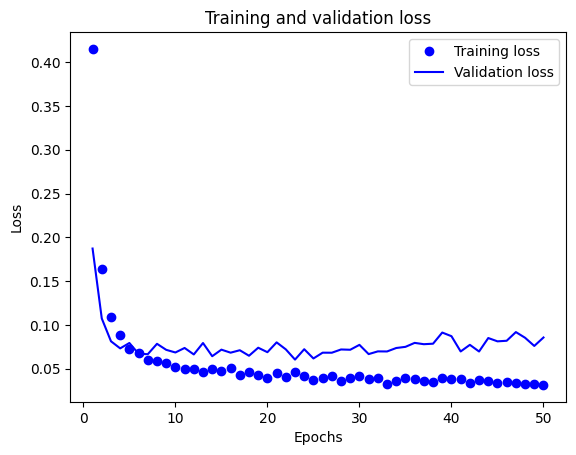

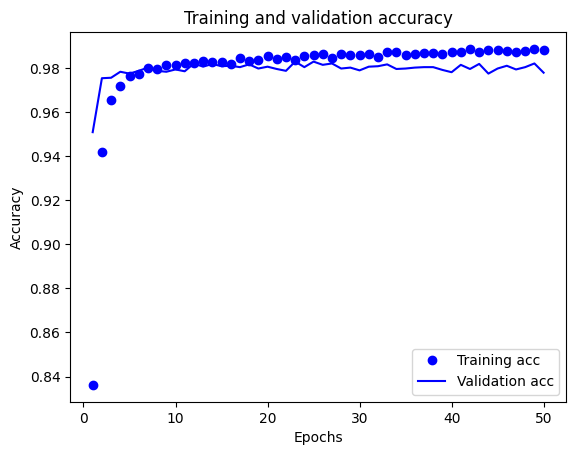

In [431]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# https://datascience.stackexchange.com/a/46524
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [432]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  hypermodel,
  layers.Activation('sigmoid')
])

In [433]:
optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate'))
export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']
)

In [434]:
export_model.save('hypermodel-string_regex_punctuation.keras', save_format="keras")
print('end=')

end=
